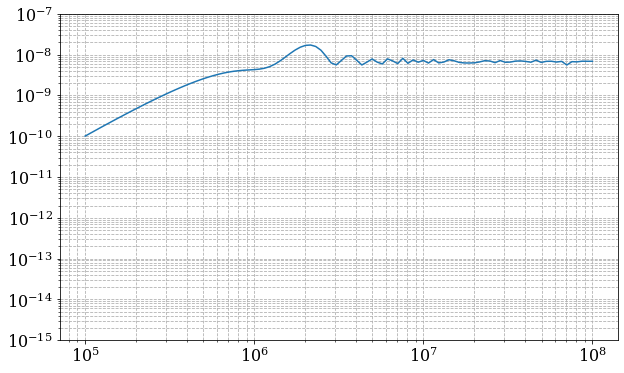

In [21]:
import numpy as np
from scipy.integrate import quad
from functools import lru_cache
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import warnings
import contextlib
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

@contextlib.contextmanager
def suppress_stdout_stderr():
    """Suppress all stdout and stderr output."""
    with open('/dev/null', 'w') as devnull:
        with contextlib.redirect_stdout(devnull), contextlib.redirect_stderr(devnull):
            yield

@lru_cache(maxsize=1024)
def alpha(g, h, eta_c, k, kc):
    term1 = (1j * (g**2 * (h + 6) + eta_c)) / (4 * g * (k/kc)**3)
    term2 = (1j * (g**2 * (h + 4) + 2 + eta_c)) / (4 * g * (k/kc))
    term3 = (g**2 + 1) / (2 * g)
    return term1 + term2 + term3

@lru_cache(maxsize=1024)
def beta(g, h, eta_c, k, kc):
    term1 = -(1j * (g**2 * (h + 6) + eta_c) * np.exp(-2j * (k/kc))) / (4 * g * (k/kc)**3)
    term2 = ((g**2 * (h + 6) + eta_c) * np.exp(-2j * (k/kc))) / (2 * g * (k/kc)**2)
    term3 = (1j * (g**2 * (h + 8) + eta_c - 2) * np.exp(-2j * (k/kc))) / (4 * g * (k/kc))
    term4 = ((g**2 - 1) * np.exp(-2j * (k/kc))) / (2 * g)
    return term1 + term2 + term3 - term4

@lru_cache(maxsize=1024)
def P_Rg(g, h, eta_c, k, kc, H, epsilon_k):
    alpha_val = alpha(g, h, eta_c, k, kc)
    beta_val = beta(g, h, eta_c, k, kc)
    term1 = (H**2) / (8 * np.pi**2 * epsilon_k)
    term2 = (alpha_val + beta_val) * (np.conjugate(alpha_val + beta_val))
    return (term1 * term2)



def p_app(g,eta_c,k,kc, H, epsilon_k):
    Pre=(H**2/(8*np.pi**2*epsilon_k))
    first_term=( eta_c + 2*(k/kc)**2 )**2 + eta_c**2 * (k/kc)**2
    second_term=( np.sin(k/kc) - (k/kc)*np.cos(k/kc) )**2
    deno=4 * g**2 * (k/kc)**6
    return ( Pre * first_term * second_term ) / (deno)



g1, h1, eta_c1 = 0.028, -0.47, -8.6e-4
mbh = 1e34
kc1 = 1 / np.sqrt((mbh / (30 * 1.989e33)) * (0.2 / 0.2) * (10.75 / 9.60) ** (-1 / 6) * (2.9e5) ** -2)
H1 = np.sqrt((7e-10 + 6.4e-15) * (1 / 3))
epsilon_k1 = 8.3e-8
F_NL=0




"""

# Use caching for power spectrum function
@lru_cache(maxsize=None)
def P_Rg_simple(k):
    return (P_Rg(g1, h1, eta_c1, k, kc1, H1, epsilon_k1)).real

"""
# Use caching for power spectrum function
@lru_cache(maxsize=None)
def P_Rg_simple(k):
    return (p_app(g1,eta_c1,k,kc1, H1, epsilon_k1)).real


# Function for the nested integrals
def compute_inner_integral(integrand, lower, upper):
    result, _ = quad(integrand, lower, upper)
    return result

# Outer integral for \Omega_{GW,eq}(k)
def omega_gw_eq(k):
    def integrand_v(v):
        def integrand_u(u):
            uv_factor = (4 * u**2 * v**2)
            pre_factor = ((4 * v**2 - (1 + v**2 - u**2)**2) / (4 * u * v))**2
            shape_factor = ((u**2 + v**2 - 3) / (2 * u * v))**4
            log_term = np.log(np.abs((3 - (u + v)**2) / (3 - (u - v)**2)))
            theta_term = np.pi**2 if u + v > np.sqrt(3) else 0
            power_spectrum_u = P_Rg_simple(u * k)
            power_spectrum_v = P_Rg_simple(v * k)
            """
            fnl_integral_u = compute_inner_integral(
                lambda nu: compute_inner_integral(
                    lambda mu: P_Rg_simple(mu * u * k) * P_Rg_simple(nu * u * k) / (mu**2 * nu**2),
                    abs(1 - nu), 1 + nu,
                ),
                0, np.inf,
            )
            fnl_integral_v = compute_inner_integral(
                lambda lam: compute_inner_integral(
                    lambda rho: P_Rg_simple(rho * v * k) * P_Rg_simple(lam * v * k) / (lam**2 * rho**2),
                    abs(1 - lam), 1 + lam,
                ),
                0, np.inf,
            )
            """
            term1 = power_spectrum_u #+ F_NL**2 *1  #fnl_integral_u
            term2 = power_spectrum_v #+ F_NL**2 *1 #fnl_integral_v
            return pre_factor * shape_factor * ((log_term - (4 * u * v / (u**2 + v**2 - 3)))**2 +theta_term)* term1 * term2 / uv_factor

        return compute_inner_integral(integrand_u, abs(1 - v), 1 + v)

    return 3 * compute_inner_integral(integrand_v, 0, np.inf)

# Parallel computation
def compute_omega_gw_parallel(k_values):
    with Pool(cpu_count()) as pool:
        with suppress_stdout_stderr():
            results = list(tqdm(pool.imap(omega_gw_eq, k_values), total=len(k_values)))
    return np.array(results)

# Example computation for a range of k values
k_values1 = np.logspace(5, 8, 100)  # Example range of k values
omega_gw_values1 = compute_omega_gw_parallel(k_values1)

# Plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.loglog(k_values1, np.array(omega_gw_values1)*1.6e-5)
plt.ylim(1e-15,1e-7)
plt.grid(True, which="both", linestyle="--")
plt.show()

In [18]:
import pandas as pd
data = {
    "k_values": k_values,
    "omega_gw_values": omega_gw_values,
}
df = pd.DataFrame(data)

# Save to a CSV file
csv_file = "omega_gw_data_32N_5.csv"
df.to_csv(csv_file, index=False)

In [19]:
import pandas as pd
import numpy as np

# Load the original CSV file
GW_32G = pd.read_csv("/docker_workplace/PBH/NonGaussian/Saskipaper/GWwaves/omega_gw_data_32N_5.csv", header=None)

# Ensure the data is numeric
GW_32G = GW_32G[pd.to_numeric(GW_32G[0], errors='coerce').notna()]
GW_32G = GW_32G[pd.to_numeric(GW_32G[1], errors='coerce').notna()]

# Convert to numpy arrays
x_original = GW_32G.iloc[:, 0].astype(float).values
y_original = GW_32G.iloc[:, 1].astype(float).values

# Define the range for x and the maximum value for the extended x range
x_min = 1e5
x_max = 1e8
x_extended_max = 1e30

# Define the new x values range (logarithmic space between x_min and x_extended_max)
num_points = 500
x_extended = np.geomspace(x_min, x_extended_max, num_points)

# Find the index where x > 1e10 starts
threshold_x = 6e7
repeat_start_index = np.argmax(x_original > threshold_x)

# Get the y-values after 1e10
y_repeating_values = y_original[repeat_start_index:]

# Initialize the extended y-values
y_extended = []

# Create the y-values for the new x_extended values
for i, x in enumerate(x_extended):
    if x <= x_max:
        # Use the original y-values for x <= 1e13
        index = np.argmin(np.abs(x_original - x))
        y_extended.append(y_original[index])
    else:
        # Repeat the y-values after 1e10 for x > 1e13
        y_extended.append(y_repeating_values[(i - len(x_original)) % len(y_repeating_values)])

# Create a DataFrame with the extended data
data_extended = pd.DataFrame({"x": x_extended, "y": y_extended})

# Save the extended data to a new CSV file
output_path = "/docker_workplace/PBH/NonGaussian/Saskipaper/GWwaves/omega_gw_data_extended_500_32N_5.csv"
data_extended.to_csv(output_path, index=False, header=False)


In [6]:
import numpy as np
from scipy.integrate import quad
from functools import lru_cache
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import warnings
import contextlib
import matplotlib.pyplot as plt
import pandas as pd
def fgw(k):
    # Constants
    factor_30_msun = 30 * 1.989e33  # 30 solar masses in grams
    ratio_factor = (10.75 / 9.60) ** (-1 / 6)
    constant_factor = (2.9e5) ** -2
    
    # Compute M_BH
    mbh = factor_30_msun / (k**2 * ratio_factor * constant_factor)
    f=(mbh/(30*1.989e33))**(-0.5)*1e-9
    return f

In [7]:
#data


GW_32Ge=pd.read_csv("/docker_workplace/PBH/NonGaussian/Saskipaper/GWwaves/omega_gw_data_extended_500.csv")
GW_34Ge=pd.read_csv("/docker_workplace/PBH/NonGaussian/Saskipaper/GWwaves/omega_gw_data_extended_500_34.csv")


#NG
GW_32GeN=pd.read_csv("/docker_workplace/PBH/NonGaussian/Saskipaper/GWwaves/omega_gw_data_extended_500_32N.csv")
GW_32GeN5=pd.read_csv("/docker_workplace/PBH/NonGaussian/Saskipaper/GWwaves/omega_gw_data_extended_500_32N_5.csv")


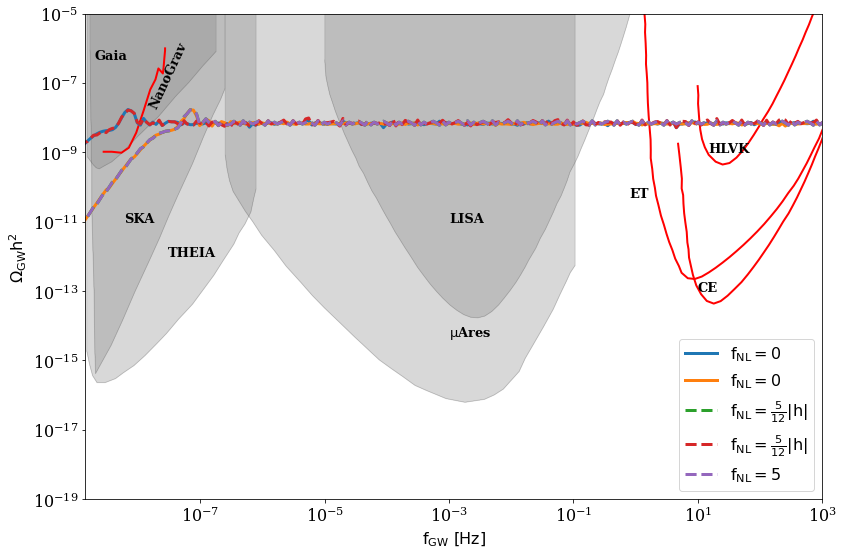

In [20]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# Set font properties for the plot
font = {'family': 'serif', 'size': 16}
plt.rc('font', **font)

# Define the figure size
plt.figure(figsize=(12, 8))

# File paths for the datasets
file_paths = {
    "SKA1": "/docker_workplace/PBH/NonGaussian/Saskipaper/GWwaves/SKA1.csv",
    "LISA": "/docker_workplace/PBH/NonGaussian/Saskipaper/GWwaves/LISA1.csv",
    "THEIA": "/docker_workplace/PBH/NonGaussian/Saskipaper/GWwaves/THEIA.csv",
    "NanGrav": "/docker_workplace/PBH/NonGaussian/Saskipaper/GWwaves/NanGrav.csv",
    "CE": "/docker_workplace/PBH/NonGaussian/Saskipaper/GWwaves/CE.csv",
    "Mu": "/docker_workplace/PBH/NonGaussian/Saskipaper/GWwaves/Mu.csv",
    "HLVK": "/docker_workplace/PBH/NonGaussian/Saskipaper/GWwaves/HLVK.csv",
    "Gaia": "/docker_workplace/PBH/NonGaussian/Saskipaper/GWwaves/Gaia.csv",
    "ET": "/docker_workplace/PBH/NonGaussian/Saskipaper/GWwaves/ET.csv"
}

# Define datasets for thick black lines
thick_black_lines = {"NanGrav", "ET", "HLVK", "CE"}

# Plot each dataset
for name, file_path in file_paths.items():
    # Load the data
    data = pd.read_csv(file_path, header=None)
    x = data.iloc[:, 0]
    y = data.iloc[:, 1]
    
    # Plot as a thick black line for specific datasets, otherwise shade
    if name in thick_black_lines:
        plt.plot(x, y, color='red', linewidth=2.0)
    else:
        plt.plot(x, y, color='black', linewidth=0.1, alpha=0.6)
        plt.fill_between(x, y, 1e10, color='gray', alpha=0.3)
        
      
     
        


# Set axis limits and scales
k_values_e=np.array( GW_34Ge.iloc[:, 0].values)
Omega_Ge=np.array( GW_34Ge.iloc[:, 1].values)*1.6e-5

k_values_e1=np.array( GW_32Ge.iloc[:, 0].values)
Omega_Ge1=np.array( GW_32Ge.iloc[:, 1].values)*1.6e-5

k_values_e1N=np.array( GW_32GeN.iloc[:, 0].values)
Omega_Ge1N=np.array( GW_32GeN.iloc[:, 1].values)*1.6e-5

k_values_e1N5=np.array( GW_32GeN5.iloc[:, 0].values)
Omega_Ge1N5=np.array( GW_32GeN5.iloc[:, 1].values)*1.6e-5


fnl_fac=np.array(Omega_Ge1N/Omega_Ge1)



plt.plot(fgw(k_values_e), Omega_Ge,linewidth=3,label="$\\rm f_{NL}=0$")
plt.plot(fgw(k_values_e1), Omega_Ge1,linewidth=3,label="$\\rm f_{NL}=0$")
plt.plot(fgw(k_values_e1N),Omega_Ge1N,'--',linewidth=3,label="$\\rm f_{NL}=\\frac{5}{12}|h|$")
plt.plot(fgw(k_values_e),Omega_Ge*fnl_fac,'--',linewidth=3,label="$\\rm f_{NL}=\\frac{5}{12}|h|$")
plt.plot(fgw(k_values_e1N5),Omega_Ge1N5,'--',linewidth=3,label="$\\rm f_{NL}=5$")

plt.xlabel("$\\rm f_{GW}~[Hz]$",**font)
plt.ylabel("$\\rm \\Omega_{GW} h^2$",**font)

plt.ylim(1e-19, 1e-5)
plt.xlim(1.4e-9, 1000)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower right')



plt.text(1.4e-8, 2e-8, 'NanoGrav', fontsize=13, color='black',fontweight='bold', rotation=65)   
plt.text(2e-9, 5e-7, 'Gaia', fontsize=13, color='black',fontweight='bold')
plt.text(6e-9, 1e-11, 'SKA', fontsize=13, color='black',fontweight='bold')
plt.text(3e-8, 1e-12, 'THEIA', fontsize=13, color='black',fontweight='bold')
plt.text(1e-3, 1e-11, 'LISA', fontsize=13, color='black',fontweight='bold')
plt.text(1e-3, 5e-15, r'$\rm\mu$Ares', fontsize=13, color='black',fontweight='bold')
plt.text(0.8,5e-11, r'ET', fontsize=13, color='black',fontweight='bold')
plt.text(10,1e-13, r'CE', fontsize=13, color='black',fontweight='bold')
plt.text(15,1e-9, r'HLVK', fontsize=13, color='black',fontweight='bold')


plt.tight_layout()
plt.savefig('GW.pdf')

plt.show()

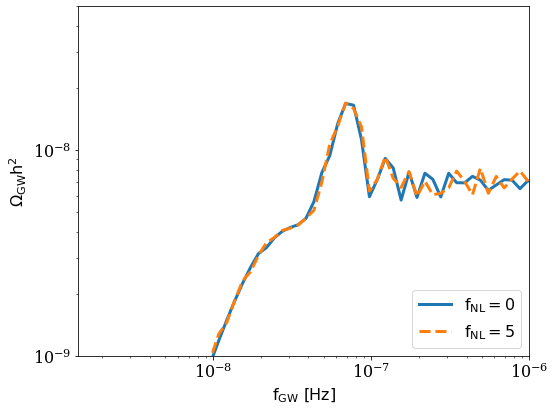

In [12]:
font = {'family': 'serif', 'size': 16}
plt.rc('font', **font)

# Define the figure size
plt.figure(figsize=(8, 6))

#plt.plot(fgw(k_values_1), Omega_G, ,linewidth=3)
#plt.plot(fgw(k_values_e), Omega_Ge,linewidth=3,label="$\\rm f_{NL}=0,~M_{PBH}\sim10^{34}~g$")
plt.plot(fgw(k_values_e1), Omega_Ge1,linewidth=3,label="$\\rm f_{NL}=0$")
plt.plot(fgw(k_values_e1N5),Omega_Ge1N5,'--',linewidth=3,label="$\\rm f_{NL}=5$")
#plt.plot(fgw(k_values_e),Omega_Ge*fnl_fac,'--',linewidth=3,label="$\\rm f_{NL}=\\frac{5}{12}|h|,~M_{PBH}\sim10^{34}~g$")

plt.xlabel("$\\rm f_{GW}~[Hz]$",**font)
plt.ylabel("$\\rm \\Omega_{GW} h^2$",**font)

plt.ylim(1e-9, 5e-8)
plt.xlim(1.4e-9, 1e-6)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('GW_Zoom.pdf')

plt.show()